In [3]:
import os
import json
import datetime
import logging
import warnings

import pandas as pd
import numpy as np
from tqdm import tqdm
# import cudf
from numba import cuda
from collections import Counter
# import cupy as cp

from sklearn.metrics import accuracy_score, precision_score, recall_score
import config as CONFIG
import utils

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [33]:

for i in tqdm(range(30)):
    if i == 22:
        continue
    mcelog = pd.read_csv(os.path.join(CONFIG.PATH_PROCESSED, f"mcelog_{i}.csv"))
    uce = mcelog[mcelog["failed_time"]!="2023-01-01 00:00:00"]
    uce.to_csv(os.path.join(CONFIG.PATH_PROCESSED, f"uce_{i}.csv"))

100%|████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:05<00:00,  2.17s/it]


In [5]:
inventory = pd.read_csv(os.path.join(CONFIG.PATH_RAW, "ali/inventory.csv"))
sms = inventory["server_manufacturer"].drop_duplicates().to_list()
dms = inventory["DRAM_model"].drop_duplicates().to_list()
dns = inventory["DIMM_number"].drop_duplicates().to_list()
sid = inventory["sid"].drop_duplicates().to_list()
dms

len(sid)

30502

In [8]:
mcelog = pd.read_csv(os.path.join(CONFIG.PATH_RAW, "ali/mcelog.csv"))

sid = mcelog["sid"].drop_duplicates().to_list()

len(sid)

30502

In [9]:
len(mcelog)

75214692

In [7]:
tourble = pd.read_csv(os.path.join(CONFIG.PATH_RAW, "ali/trouble_tickets.csv"))

sid = tourble["sid"].drop_duplicates().to_list()

len(sid)

3017

In [184]:

d = {}
for i in tqdm(range(29)):
    if i == 22:
        continue
    mcelog = pd.read_csv(os.path.join(CONFIG.PATH_PROCESSED, f"mcelog_{i}.csv"))
    mcelog = cudf.DataFrame(mcelog)
    for sm in sms:
        for dm in dms:
            k = f"{sm}_{dm}"
            if k in d.keys():
                d[k] = d[k] + len(mcelog[(mcelog["server_manufacturer"]==sm)&(mcelog["DRAM_model"]==dm)])
            else:
                d[k] = len(mcelog[(mcelog["server_manufacturer"]==sm)&(mcelog["DRAM_model"]==dm)])
print(d)

100%|████████████████████████████████████████████████████████████████████████████████████████| 29/29 [03:08<00:00,  6.48s/it]

{'M2_C1': 4648119, 'M2_A2': 4932162, 'M2_C2': 439458, 'M2_B1': 2787994, 'M2_A1': 4887160, 'M2_B2': 16722, 'M2_B3': 178630, 'M1_C1': 1646525, 'M1_A2': 1984258, 'M1_C2': 548454, 'M1_B1': 1302117, 'M1_A1': 1599472, 'M1_B2': 2122, 'M1_B3': 86563, 'M3_C1': 796594, 'M3_A2': 998428, 'M3_C2': 78156, 'M3_B1': 5398943, 'M3_A1': 4291891, 'M3_B2': 6968, 'M3_B3': 58242, 'M4_C1': 3706825, 'M4_A2': 0, 'M4_C2': 0, 'M4_B1': 96842, 'M4_A1': 82, 'M4_B2': 0, 'M4_B3': 0}


In [42]:
import pandas as pd

# 创建示例 DataFrame
data = {'Group1': ['A', 'A', 'B', 'A', 'A'],
        'Group2': ['X', 'Y', 'X', 'Y', 'X'],
        'Value': [10, 20, 30, 40, 50]}
df = pd.DataFrame(data)

# 使用 groupby 对 'Group1' 和 'Group2' 列进行分组，并计算 'Value' 列的最大值
result = df.groupby(['Group1', 'Group2'])['Value'].max().reset_index()

print(result)


  Group1 Group2  Value
0      A      X     50
1      A      Y     40
2      B      X     30


In [57]:
grouped_list = []
for i in tqdm(range(30)):
    if i == 22:
        continue
    mcelog = pd.read_csv(os.path.join(CONFIG.PATH_PROCESSED, f"mcelog_{i}.csv"))
    mcelog_cudf = cudf.DataFrame(mcelog)
    mcelog_cudf = mcelog_cudf[["row", "col", "server_manufacturer", "DRAM_model", "DIMM_number"]]

    grouped_one = mcelog_cudf.groupby(['server_manufacturer', 'DRAM_model',"DIMM_number"])['col'].max().reset_index()
    # grouped_one = mcelog_cudf.groupby(['server_manufacturer', 'DRAM_model',"DIMM_number"])['col'].max().reset_index()
    grouped_list.append(grouped_one)
grouped = cudf.concat(grouped_list, axis=0)
grouped = grouped.groupby(['server_manufacturer'])['col'].max().reset_index()
print(grouped)

100%|████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:09<00:00,  2.32s/it]

  server_manufacturer   col
0                  M1  1016
1                  M2  1016
2                  M4  1016
3                  M3  1016


In [56]:
grouped_test = grouped.groupby(['server_manufacturer'])['row'].max().reset_index()
grouped_test

,server_manufacturer,row
0,M4,131071
1,M2,131071
2,M1,131071
3,M3,131071


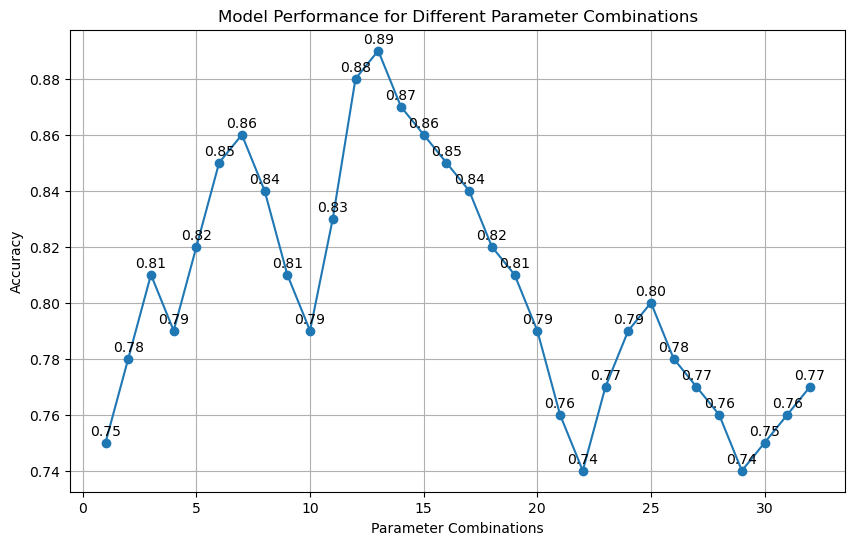

In [11]:
import matplotlib.pyplot as plt

# 假设你有32个参数组合的性能数据，这里使用随机数据代替
param_combinations = list(range(1, 33))
accuracy = [0.75, 0.78, 0.81, 0.79, 0.82, 0.85, 0.86, 0.84, 0.81, 0.79, 0.83, 0.88, 0.89, 0.87, 0.86, 0.85, 0.84, 0.82, 0.81, 0.79, 0.76, 0.74, 0.77, 0.79, 0.80, 0.78, 0.77, 0.76, 0.74, 0.75, 0.76, 0.77]  # 32个性能指标值

# 绘制折线图
plt.figure(figsize=(10, 6))
plt.plot(param_combinations, accuracy, marker='o', linestyle='-')
plt.xlabel('Parameter Combinations')
plt.ylabel('Accuracy')
plt.title('Model Performance for Different Parameter Combinations')
plt.grid(True)

# 添加标签
for i, acc in enumerate(accuracy):
    plt.annotate(f'{acc:.2f}', (param_combinations[i], accuracy[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()


In [8]:
mcelog.head()

,Unnamed: 0.1,Unnamed: 0,sid,memoryid,rankid,bankid,row,col,error_type,error_time,server_manufacturer,DRAM_model,DIMM_number,failure_type,failed_time
0,38983971,38983971,Server_30255,22,0,9,41976,744,2,2019-10-23 17:19:02,M4,B1,12,NaN,2023-01-01 00:00:00
1,38983972,38983972,Server_30255,22,0,9,41976,744,2,2020-01-01 01:16:50,M4,B1,12,NaN,2023-01-01 00:00:00
2,38983973,38983973,Server_30255,22,0,9,41976,744,2,2020-01-02 01:03:05,M4,B1,12,NaN,2023-01-01 00:00:00
3,38983974,38983974,Server_30255,22,0,9,41976,744,2,2020-01-05 00:21:51,M4,B1,12,NaN,2023-01-01 00:00:00
4,38983975,38983975,Server_30255,22,0,9,41976,744,2,2020-01-06 23:54:22,M4,B1,12,NaN,2023-01-01 00:00:00


In [63]:
import cudf

# 创建一个示例的 cudf DataFrame
data = {'numbers': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 131071, 1016]}
df = cudf.DataFrame(data)

# 计算每个值在 2^N 和 2^(N+1) 之间的 N
def calculate_n(x):
    n = 0
    while x >= 2 ** (n + 1):
        n += 1
    width = 2 ** (n+1)//(n+1)
    return n

df['n_values'] = df['numbers'].apply(calculate_n)

print(df)

if df["numbers"].sum() > 10:
    print("ddd")

    numbers  n_values
0         1         0
1         2         1
2         3         1
3         4         2
4         5         2
5         6         2
6         7         2
7         8         3
8         9         3
9        10         3
10   131071        16
11     1016         9
ddd


In [13]:
feats = np.load(os.path.join(CONFIG.PATH_PROCESSED, f"feats_64x32_with_times_multichannles.npy")).astype(np.float32)

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/feats_64x32_with_times_multichannles.npy'

In [61]:
2 ** 17 / 17

7710.117647058823

In [331]:
mcelog = pd.read_csv(os.path.join(CONFIG.PATH_PROCESSED, f"mcelog_6.csv"))
df_cudf = cudf.DataFrame(mcelog)

In [318]:

def check_one(df_cudf):
    tps = []
    fps = []
    fns = []
    
    
    hosts = df_cudf["sid"].drop_duplicates().to_arrow().to_pylist()
    logging.info(f"hosts: {len(hosts)}")

    reals = []
    preds = []
    max_row = 131072
    max_col = 1024
    row_block = 32
    col_block = 16
    row_section_size = max_row // row_block
    col_section_size = max_col // col_block
    
    for host in tqdm(hosts):
        ret_d = {}
        host_cudf = df_cudf[df_cudf["sid"]==host]
        host_cudf = host_cudf.fillna(-1)
        if host_cudf["failure_type"].sum() < 0:
            real = 0
            reals.append(0)
        else:
            real = 1
            reals.append(1)
        host_cudf["row_max"] = host_cudf["row"].max()
        host_cudf["row_min"] = host_cudf["row"].min()
        host_cudf["row_gap"] = host_cudf["row_max"] - host_cudf["row_min"]
        host_cudf["col_max"] = host_cudf["col"].max()
        host_cudf["col_min"] = host_cudf["col"].min()
        host_cudf["col_gap"] = host_cudf["col_max"] - host_cudf["col_min"]
        
        host_cudf["row_section"] = host_cudf["row"] // row_section_size
        host_cudf["col_section"] = host_cudf["col"] // col_section_size
        
        # uce
        # # rule 1
        # host_cudf_grouped = host_cudf.groupby(["memoryid","rankid","bankid","row_section"]).agg({"col_section": ["max", "min"]})
        # host_cudf_grouped.columns = ["max", "min"]
        # host_cudf_grouped = host_cudf_grouped.reset_index()
        # host_cudf_grouped["col_gap"] = host_cudf_grouped["max"] - host_cudf_grouped["min"]
        # host_cudf_grouped = host_cudf_grouped[(host_cudf_grouped["col_gap"]>= (col_block / 2))]
        # ret_d["uce_rule_1"] = int(len(host_cudf_grouped)>0)
        # # rule 2
        # host_cudf_grouped = host_cudf.groupby(["memoryid","rankid","bankid","col_section"]).agg({"row_section": ["max", "min"]})
        # host_cudf_grouped.columns = ["max", "min"]
        # host_cudf_grouped = host_cudf_grouped.reset_index()
        # host_cudf_grouped["row_gap"] = host_cudf_grouped["max"] - host_cudf_grouped["min"]
        # host_cudf_grouped = host_cudf_grouped[(host_cudf_grouped["row_gap"]>= (row_block / 2))]
        # ret_d["uce_rule_2"] = int(len(host_cudf_grouped)>0)
        # rule 3
        ret_d["uce_rule_3"] = int(len(host_cudf[(host_cudf["col_section"]==15)&(host_cudf["row_section"]>=30)])>0)
        # rule 4
        ret_d["uce_rule_4"] = int(len(host_cudf[(host_cudf["row_section"]>=30)&(host_cudf["row_section"]>=14)])>0)
        
        # not uce
        # # rule 1
        # ret_d["non_uce_rule_1"] = ((host_cudf["row_section"].max() - host_cudf["row_section"].min()) ==0).astype(int)
        # # rule 2
        # ret_d["non_uce_rule_2"] = (host_cudf["col"] <= (max_col / 2)).all().astype(int)
        # # rule 3
        # row_sections = host_cudf["row_section"].drop_duplicates().to_arrow().to_pylist()
        # flag = 1
        # for i in range(len(row_sections) - 1):
        #     flag = flag & int((row_sections[i+1] - row_sections[i]) > 1)
        # ret_d["non_uce_rule_2"] = flag
        
        # force uce
        # host_cudf["col_border"] = (host_cudf["col_section"] == ).astype(int
        
                    
        pred = 0
        for k, v in ret_d.items():
            if "non_uce" not in k:
                pred = pred or v
            else:
                if v == 1:
                    pred = 0
                    break
        # pred = (pred + 1) % 2
        if host == "Server_3837":
            logging.info(f"{pred}")
        preds.append(pred)
        
        if real==0 and pred == 1:
            fps.append(host)
        if real==1 and pred == 0:
            fns.append(host)
        if real==0 and pred == 1:
            fps.append(host)
        if real==1 and pred == 1:
            tps.append(host)
            
    # print(fps)
    # print(fns)
    # print(reals)
    precision = precision_score(reals, preds)
    recall = recall_score(reals, preds)

    print("precision {}".format(precision))
    print("recall {}".format(recall))
    return reals, preds, fps, fns, tps

In [319]:
reals, preds, fps, fns, tps = check_one(df_cudf)

2023-09-06 10:47:33,916 - INFO - hosts: 1906
100%|████████████████████████████████████████████████████████████████████████████████████| 1906/1906 [01:07<00:00, 28.34it/s]

precision 0.057692307692307696
recall 0.3


In [313]:
hosts = df_cudf["sid"].drop_duplicates().to_arrow().to_pylist()

max_row = 131072
max_col = 1024

row_block = 32
col_block = 16

row_section_size = max_row // row_block
col_section_size = max_col // col_block

cursor_fp_num = 20
cursor_fn_num = 20
cursor_fp = 0
cursor_fn = 0
for host in hosts:
    if host in tps or host in fps or host in fns:
        tmp = df_cudf[df_cudf["sid"]==host][["sid", "memoryid","rankid","bankid", "row", "col", "error_time","failed_time"]]
        tmp = tmp.sort_values(["sid", "memoryid","rankid","bankid", "row"])
        tmp["row_section"] = tmp["row"] // row_section_size
        tmp["col_section"] = tmp["col"] // col_section_size
        tmp["col_border"] = int(len(tmp[(tmp["col_section"]==15)&(tmp["row_section"]>=30)])>0)
        if host in tps:
            tmp.to_csv(f"tp_one_{host}.csv")
        if host in fps and cursor_fp < cursor_fp_num:
            tmp.to_csv(f"fp_one_{host}.csv")
            cursor_fp += 1
        if host in fns and cursor_fn < cursor_fn_num:
            tmp.to_csv(f"fn_one_{host}.csv")
            cursor_fn += 1

## CNN

In [330]:
import numpy as np

a = np.zeros([2,2])

a[1,1] = 1

a

array([[0., 0.],
       [0., 1.]])

In [334]:
mcelog = pd.read_csv(os.path.join(CONFIG.PATH_PROCESSED, f"mcelog_6.csv"))
df_cudf = cudf.DataFrame(mcelog)
df = pd.DataFrame(mcelog)

In [374]:
data = []
labels = []

max_row = 131072
max_col = 1024
row_block = 32
col_block = 16
row_section_size = max_row // row_block
col_section_size = max_col // col_block

hosts = df["sid"].drop_duplicates().to_list()

for host in tqdm(hosts):
    
    host_matrix = np.zeros([row_block, col_block])
    
    host_df = df[df["sid"]==host]
    host_df = host_df.fillna(-1)
    if host_df["failure_type"].sum() < 0:
        labels.append(0)
    else:
        labels.append(1)

    host_df["row_section"] = host_df["row"] // row_section_size
    host_df["col_section"] = host_df["col"] // col_section_size
    
    host_df_simple = host_df[["row_section", "col_section"]].drop_duplicates()
    
    for _, row in host_df_simple.iterrows():
        host_matrix[int(row["row_section"]), int(row["col_section"])] = 1
        
    # np.savetxt("one.txt", host_matrix, fmt="%d", delimiter="\t")
        
    data.append(host_matrix)
    
    # # print(data)
    # print(host_df)
    # print(labels)
    # if 1 in labels:
    #     print(labels)
    #     break

100%|████████████████████████████████████████████████████████████████████████████████████| 1906/1906 [05:46<00:00,  5.49it/s]


In [375]:
data_
data_0906 = data
labels_0906 = labels


In [376]:
alldata = [torch.tensor(matrix, dtype=torch.float32) for matrix in data]
alllabels = torch.tensor(labels, dtype=torch.long)

In [377]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_score, recall_score


# # 示例数据：假设有3个矩阵，每个矩阵为16x32，每个矩阵中的值是0或1，每个矩阵有一个标签（0或1）
# # 请根据您的实际数据替换这些示例数据
# num_matrices = 3
# matrix_size = (16, 32)
# data = [np.random.randint(0, 2, matrix_size) for _ in range(num_matrices)]
# labels = [0, 1, 0]  # 示例标签

# # 数据预处理：将数据转换为PyTorch张量
# data = [torch.tensor(matrix, dtype=torch.float32) for matrix in data]
# labels = torch.tensor(labels, dtype=torch.long)


# class CNNModel(nn.Module):
#     def __init__(self):
#         super(CNNModel, self).__init__()
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(32 * 8 * 4, 128)
#         self.fc2 = nn.Linear(128, 2)  # 2表示二分类任务

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.relu(self.conv2(x))
#         x = x.view(x.size(0), -1)
#         x = torch.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

X = torch.tensor(data, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)  # 通常标签为整数

print(len(X))
print(len(y))

import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 16 * 8, 64)  # 32x16矩阵通过1次池化后变成16x8
        self.fc2 = nn.Linear(64, 2)  # 2个类别

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 创建自定义数据集
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 创建数据加载器
dataset = CustomDataset(X, y)
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    
# 创建模型实例
model = CNNModel()

criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数适用于分类问题
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for _inputs, _labels in data_loader:
        optimizer.zero_grad()
        outputs = model(_inputs.unsqueeze(1))  # 在通道维度上增加1
        loss = criterion(outputs, _labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(data_loader)}')

print('Finished Training')


model.eval()
correct = 0
total = 0

predictions = []
true_labels = []

with torch.no_grad():
    for _inputs, _labels in data_loader:
        outputs = model(_inputs.unsqueeze(1))
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(_labels.tolist())

precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)

print(f'Precision: {precision}')
print(f'Recall: {recall}')

1906
1906
Epoch 1/10, Loss: 0.12285896251366163
Epoch 2/10, Loss: 0.07264579604379832
Epoch 3/10, Loss: 0.06518378579057753
Epoch 4/10, Loss: 0.059615418097625175
Epoch 5/10, Loss: 0.05593374476302415
Epoch 6/10, Loss: 0.05001118544411535
Epoch 7/10, Loss: 0.041362975747324525
Epoch 8/10, Loss: 0.034361539831540236
Epoch 9/10, Loss: 0.029613858313920598
Epoch 10/10, Loss: 0.024444700191573552
Finished Training
Precision: 1.0
Recall: 0.6153846153846154


In [ ]:
data = []
labels = []

max_row = 131072
max_col = 1024
row_block = 32
col_block = 16
row_section_size = max_row // row_block
col_section_size = max_col // col_block

hosts = df["sid"].drop_duplicates().to_list()

for host in tqdm(hosts):
    
    host_matrix = np.zeros([row_block, col_block])
    
    host_df = df[df["sid"]==host]
    host_df = host_df.fillna(-1)
    if host_df["failure_type"].sum() < 0:
        labels.append(0)
    else:
        labels.append(1)

    host_df["row_section"] = host_df["row"] // row_section_size
    host_df["col_section"] = host_df["col"] // col_section_size
    
    host_df_simple = host_df[["row_section", "col_section"]].drop_duplicates()
    
    for _, row in host_df_simple.iterrows():
        host_matrix[int(row["row_section"]), int(row["col_section"])] = 1
        
    # np.savetxt("one.txt", host_matrix, fmt="%d", delimiter="\t")
        
    data.append(host_matrix)
    
    # # print(data)
    # print(host_df)
    # print(labels)
    # if 1 in labels:
    #     print(labels)
    #     break

In [285]:
1 or 5

1

In [308]:
reals_list = []
preds_list = []
for i in range(29):
    if i == 22:
        continue
    mcelog1 = pd.read_csv(os.path.join(CONFIG.PATH_PROCESSED, f"mcelog_{i}.csv"))
    df_cudf = cudf.DataFrame(mcelog1)
    reals, preds, fpss, fnss = check_one(df_cudf)
    reals_list.extend(reals)
    preds_list.extend(preds)
precision = precision_score(reals_list, preds_list)
recall = recall_score(reals_list, preds_list)

print("precision {}".format(precision))
print("recall {}".format(recall))


2023-09-06 09:26:38,087 - INFO - hosts: 1906
100%|████████████████████████████████████████████████████████████████████████████████████| 1906/1906 [01:55<00:00, 16.47it/s]


precision 0.14594594594594595
recall 0.7788461538461539


2023-09-06 09:28:37,449 - INFO - hosts: 1906
100%|████████████████████████████████████████████████████████████████████████████████████| 1906/1906 [01:52<00:00, 16.93it/s]


precision 0.05653710247349823
recall 0.7619047619047619


2023-09-06 09:30:39,541 - INFO - hosts: 1906
100%|████████████████████████████████████████████████████████████████████████████████████| 1906/1906 [02:01<00:00, 15.73it/s]


precision 0.031914893617021274
recall 0.42857142857142855


2023-09-06 09:32:53,687 - INFO - hosts: 1906
 11%|█████████▋                                                                           | 218/1906 [00:13<01:46, 15.90it/s]


KeyboardInterrupt: 

In [138]:
host_cudf = df_cudf[df_cudf["sid"]=="Server_139"].sort_values(["row"], ascending=True)
host_cudf
# host_cudf["grouped"] = host_cudf["memoryid"] + host_cudf["rankid"] + host_cudf["bankid"] + host_cudf["col"]
# host_cudf_grouped = host_cudf.groupby("grouped").agg({"row": ["max", "min"]})
# host_cudf_grouped.columns = ["max", "min"]
# host_cudf_grouped["col_gap"] = host_cudf_grouped["max"] - host_cudf_grouped["min"]
# host_cudf_grouped = host_cudf_grouped.reset_index()
# host_cudf_grouped

,Unnamed: 0,sid,memoryid,rankid,bankid,row,col,error_type,error_time,server_manufacturer,DRAM_model,DIMM_number,failure_type,failed_time
97915,97915,Server_139,22,0,3,0,1016,1,2019-12-23 08:10:51,M2,B1,12,<NA>,2023-01-01 00:00:00
97952,97952,Server_139,22,0,3,1,1016,1,2019-12-23 08:30:43,M2,B1,12,<NA>,2023-01-01 00:00:00
97993,97993,Server_139,22,0,3,2,1016,1,2019-12-23 09:02:34,M2,B1,12,<NA>,2023-01-01 00:00:00
97772,97772,Server_139,22,0,3,3,1016,1,2019-12-23 07:31:53,M2,B1,12,<NA>,2023-01-01 00:00:00
98030,98030,Server_139,22,0,3,5,1016,1,2019-12-23 09:36:51,M2,B1,12,<NA>,2023-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97919,97919,Server_139,22,0,3,67561,1016,1,2019-12-23 08:12:59,M2,B1,12,<NA>,2023-01-01 00:00:00
97921,97921,Server_139,22,0,3,67562,1016,1,2019-12-23 08:12:59,M2,B1,12,<NA>,2023-01-01 00:00:00
97920,97920,Server_139,22,0,3,67563,1016,1,2019-12-23 08:12:59,M2,B1,12,<NA>,2023-01-01 00:00:00
97922,97922,Server_139,22,0,3,67564,1016,1,2019-12-23 08:12:59,M2,B1,12,<NA>,2023-01-01 00:00:00


In [78]:
import pandas as pd

# 创建示例DataFrame
data = {'A': ['X', 'X', 'Y', 'Y', 'X'],
        'B': ['1', '2', '1', '2', '1'],
        'd': [1,2,3,4,5],
        'C': [10, 20, 30, 40, 50]}
df = pd.DataFrame(data)

# 将A和B列组合成一个新的列以进行分组
df['AB_group'] = df['A'] + df['B']

# 使用groupby按AB_group分组，然后计算C列的最大值和最小值
result = df.groupby('AB_group')['C'].agg([max, min]).reset_index()

# 计算最大值和最小值的差值
result['差值'] = result['max'] - result['min']

if (result['差值']>40).any():
    print("ff")
else:
    print("------")

print(result)

print((result['差值']>20).any().astype(int))

------
  AB_group  max  min  差值
0       X1   50   10  40
1       X2   20   20   0
2       Y1   30   30   0
3       Y2   40   40   0
1


In [203]:
import cudf

# 创建一个示例DataFrame，假设有两列：'column1'和'column2'
# data = {'column1': [1, 1, 2, 2, 3, 3],
#         'column2': [10, 20, 15, 25, 30, 40]}
data = {'column1': ['X', 'X', 'Y', 'Y', 'X'],
        'column2': ['1', '2', '1', '2', '1'],
        'd': [1,1,1,1,1],
        'C': [10, 20, 30, 40, 50]}
df = cudf.DataFrame(data)
# 使用groupby根据'column1'进行分组，并计算第二列的最大值和最小值
grouped = df.groupby('column1').agg({'column2': ['max', 'min']})

# 重命名列
grouped.columns = ['max', 'min']

# 重置索引以将'column1'作为列而不是索引
grouped = grouped.reset_index()

# 打印结果
print(grouped)


  column1 max min
0       X   2   1
1       Y   2   1


In [209]:
import cudf

# 创建一个示例DataFrame，假设有两列：'column1'和'column2'
# data = {'column1': [1, 1, 2, 2, 3, 3],
#         'column2': [10, 20, 15, 25, 30, 40]}
data = {'column1': ['X', 'X', 'Y', 'Y', 'X'],
        'column2': ['1', '2', '1', '2', '1'],
        'd': [1,1,1,1,1],
        'C': [10, 20, 30, 40, 50]}
df = pd.DataFrame(data)
# 使用groupby根据'column1'进行分组，并计算第二列的最大值和最小值
grouped = df.groupby(['column1','d']).agg({'column2': ['max', 'min']})

# 重命名列
grouped.columns = ['max', 'min']

# 重置索引以将'column1'作为列而不是索引
grouped = grouped.reset_index()

# 打印结果
print(grouped)


  column1  d max min
0       X  1   2   1
1       Y  1   2   1


In [196]:
data = {'column1': [1, 1, 2, 2, 3, 3],
        'column2': [10, 20, 15, 25, 30, 40]}

df = cudf.DataFrame(data)

((df["column2"].max() - df["column2"].min())<50).astype(int)

1

In [ ]:
data = {'column1': [1, 1, 2, 2, 3, 3],
        'column2': [10, 20, 15, 25, 30, 40]}

df = cudf.DataFrame(data)

df = df

In [378]:
import torch

torch.cuda.is_available()

True